# Sinkhorn algorithm
## Regularized OT
We define the discrete entropy of a coupling matrix as :
$$\mathbf{H(P)} \overset{\text{def}}{=} - \sum_{i,j}P_{i,j} (\log P_{i,j} - 1)$$

We then modify the original optimal transport problem to define :
$$L_C^\varepsilon(a,b) \overset{\text{def}}{=} \min_{P \in U(a,b)} \left\langle P, C\right\rangle - \epsilon H(P)$$

We have that :
$$L_C^\varepsilon(a,b) \overset{\varepsilon \to 0}{\longrightarrow} L_C(a,b)$$

The advantage of this regularized $L_C^\varepsilon$ problem is that it as a solution of a specific form :

---
The solution $L_C^\varepsilon$ is unique and has the form :
$$P = \mathrm{diag}(u) K \mathrm{diag}(v)$$
With :
 - $K = \exp(-\frac{C}{\varepsilon})$
 - $u = \exp(\frac{f}{\varepsilon}), v = \exp(\frac{g}{\varepsilon})$, where $f$ and $g$ are the Kantorovich potentials.
---

A simple and efficient algorithm to find a solution to this problem is then to use matrix scaling. This algorithm is called Sinkhorn algorithm and iterates as follow :
    $$u^{(l+1)} = \frac{a}{Kv^{(l)}}, v^{(l+1)} = \frac{b}{Ku^{(l+1)}}$$


In [24]:
import sys
sys.path.append("..")
import matplotlib.pyplot as plt 
from sklearn.datasets import make_moons, make_circles
from scipy.spatial import distance_matrix
from refldesign.problem import build_problem
from refldesign.solvers import sorted1d, sinkhornlog
from refldesign.tools import approxmap, sinkhornplan
import numpy as np
import tensorflow as tf

from cvxopt import matrix, solvers
%matplotlib inline

Here, we define the same distributions as in the LP formulation.

In [27]:
C, a, b, mu, nu = build_problem(256,256)
n = mu.shape[0]
m = nu.shape[0]

In [12]:
n = 100
m = 100
moons, mclass = make_circles(max(n,m)*2, noise = 0.15, factor=0.6, random_state=42)
#moons, mclass = make_moons(max(n,m)*2, noise = 0.15)
np.random.seed(42)
axy = moons[mclass==0][:n]
a = np.random.rand(n, 1)
a = a/np.sum(a)

bxy = moons[mclass==1][:m]
b = np.random.rand(m, 1)
b = b/np.sum(b)

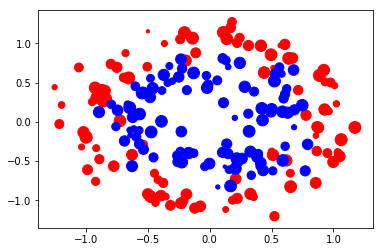

In [13]:
plt.scatter(axy[:,0], axy[:,1], s = a**(1/2)*1000, c="red")
plt.scatter(bxy[:,0], bxy[:,1], s = b**(1/2)*1000, c="blue")

In [14]:
C = distance_matrix(axy, bxy, p=2)**2

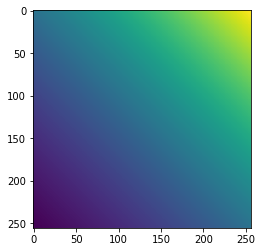

In [28]:
plt.imshow(C)

We choose a regularisation parameters $\epsilon$, close to 0.

In [70]:
eps = 0.1

In [71]:
K = np.exp(-C/eps)

We iterate until the solution converges to a good solution.

In [72]:
ou = np.zeros((n,))
ov = np.zeros((m,))
u = np.ones((n,))/n
v = np.ones((m,))/m
a = tf.reshape(a, [-1, 1])
b = tf.reshape(b, [-1, 1])
while np.sum((ou - u)**2) > 1e-2 or np.sum((ov - v)**2) > 1e-2:
    ou = u
    ov = v
    u = a/(K@v)
    v = b/(K.T@u)

We can find the plan $P$ using the formula as defined in the sinkhorn algorithm.

In [73]:
P = np.diag(u)@K@np.diag(v)

In [74]:
cost = np.sum(np.multiply(C,P))
print(f"Total cost : {cost}")

Total cost : 2.3843608778899942e-14


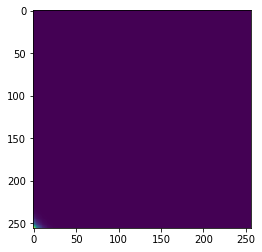

In [75]:
plt.imshow(P)

We find a solution with a cost somewhat close the the solution found using LP. 

IndexError: index 100 is out of bounds for axis 0 with size 100

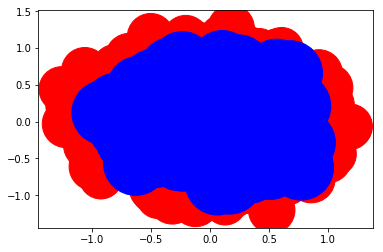

In [76]:
plt.scatter(axy[:,0], axy[:,1], s = a**(1/2)*2000, c="red")
plt.scatter(bxy[:,0], bxy[:,1], s = b**(1/2)*2000, c="blue")
maxP = np.max(P)
for i in range(n):
    for j in range(m):
        plt.plot([axy[i,0], bxy[j,0]], [axy[i,1], bxy[j,1]], linewidth=P[i,j]*5/maxP, linestyle="-", c="black")

# Sinkhorn in Log-Domain

We use Sinkhorn iterations in logdomain, which can be written, simply taking the log of the previous iterates, as :
    $$\log u^{(l+1)} = \log\frac{a}{Kv^{(l)}}, \log v^{(l+1)} = \log\frac{b}{Ku^{(l+1)}}$$
    $$\frac{f^{(l+1)}}{\varepsilon} = \log a - \log Kv^{(l)}, \frac{g^{(l+1)}}{\varepsilon} = \log b - \log Ku^{(l+1)}$$
    $$f^{(l+1)} = \varepsilon \log a - \varepsilon \log Kv^{(l)}, g^{(l+1)} = \varepsilon \log b - \varepsilon \log Ku^{(l+1)}$$
    
We define softmin as :
$$\min_\varepsilon \overset{\text{def}}{=} -\varepsilon \log \sum_i e^{-z_i/\varepsilon}$$

We can then rewrite the iterates as :
    $$f^{(l+1)}_i = \varepsilon \log a - \varepsilon \min_\varepsilon (C_i - g^{(l)}), g^{(l+1)}_i = \varepsilon \log b - \varepsilon \min_\varepsilon(C_i - f^{(l+1)})$$

In [98]:
n

256

In [91]:
eps = 1
K = np.exp(-C/eps)

Here, we use the TensorFlow implementation of *LogSumExp* (LSE) reduction.

This implementation uses the following trick :
Given a vector $x$, we write $\underline{x} = \max x$ and then write LSE as :
$$\log \sum_i e^{x_i} = \log \sum_i e^{x_i - \underline{x}}e^\underline{x} = \underline{x} + \log \sum_i e^{x_i - \underline{x}}$$

In [92]:
def shsoftmin(z, eps, axis=1):
    return -eps * tf.math.reduce_logsumexp(-z/eps, axis=axis)

In [95]:
of = tf.zeros((n,), dtype=tf.float64)
og = tf.zeros((m,), dtype=tf.float64)
f = tf.ones((n,), dtype=tf.float64)/n
g = tf.ones((m,), dtype=tf.float64)/m
a = tf.reshape(a, [-1, 1])
b = tf.reshape(b, [-1, 1])

while tf.math.reduce_max((of - f)**2) > 1e-5 or tf.math.reduce_max((og - g)**2) > 1e-5:
    of = f
    og = g
    print(f,g)
    f = eps*tf.math.log(a) + shsoftmin(C - tf.expand_dims(g, axis=0), eps, axis=1)
    g = eps*tf.math.log(b) + shsoftmin(C - tf.expand_dims(f, axis=1), eps, axis=0)

tf.Tensor(
[0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.00390625 0.0039

tf.Tensor(
[[ 3.10176161  3.06133052  3.0209723  ... -4.83881837 -4.86127595
  -4.88366526]
 [ 3.10957415  3.06914306  3.02878484 ... -4.83100584 -4.85346341
  -4.87585272]
 [ 3.11732613  3.07689503  3.03653682 ... -4.82325386 -4.84571144
  -4.86810074]
 ...
 [ 4.1951314   4.15470031  4.11434209 ... -3.74544859 -3.76790616
  -3.79029547]
 [ 4.19775607  4.15732498  4.11696676 ... -3.74282391 -3.76528149
  -3.7876708 ]
 [ 4.20037387  4.15994278  4.11958456 ... -3.74020611 -3.76266369
  -3.785053  ]], shape=(256, 256), dtype=float64) tf.Tensor(
[[ 1.89739103  1.97656439  2.05574078 ... 22.05901432 22.13941455
  22.2198224 ]
 [ 1.86029204  1.93938952  2.01849001 ... 22.00271495 22.08303929
  22.16337125]
 [ 1.8232665   1.90228808  1.98131268 ... 21.94648902 22.02673747
  22.10699354]
 ...
 [-5.13172701 -5.07175402 -5.01177802 ... 10.17219946 10.23339931
  10.29460678]
 [-5.15007067 -5.09017358 -5.03027347 ... 10.13465541 10.19577937
  10.25691095]
 [-5.16833971 -5.10851851 -5.04869429 ... 

tf.Tensor(
[[ -5.68713645  -5.72756754  -5.76792576 ... -13.62771643 -13.65017401
  -13.67256332]
 [ -5.67932391  -5.719755    -5.76011322 ... -13.61990389 -13.64236147
  -13.66475078]
 [ -5.67157193  -5.71200302  -5.75236124 ... -13.61215192 -13.63460949
  -13.6569988 ]
 ...
 [ -4.59376666  -4.63419775  -4.67455597 ... -12.53434664 -12.55680422
  -12.57919353]
 [ -4.59114199  -4.63157308  -4.6719313  ... -12.53172197 -12.55417955
  -12.57656885]
 [ -4.58852418  -4.62895527  -4.66931349 ... -12.52910417 -12.55156174
  -12.57395105]], shape=(256, 256), dtype=float64) tf.Tensor(
[[10.68628909 10.76546245 10.84463883 ... 30.84791237 30.9283126
  31.00872046]
 [10.6491901  10.72828757 10.80738807 ... 30.791613   30.87193734
  30.95226931]
 [10.61216455 10.69118614 10.77021074 ... 30.73538707 30.81563552
  30.8958916 ]
 ...
 [ 3.65717105  3.71714403  3.77712003 ... 18.96109752 19.02229737
  19.08350484]
 [ 3.63882738  3.69872448  3.75862459 ... 18.92355347 18.98467743
  19.04580901]
 [ 3.62

tf.Tensor(
[[-14.4760345  -14.51646559 -14.55682381 ... -22.41661449 -22.43907206
  -22.46146137]
 [-14.46822196 -14.50865305 -14.54901127 ... -22.40880195 -22.43125952
  -22.45364883]
 [-14.46046999 -14.50090108 -14.5412593  ... -22.40104997 -22.42350755
  -22.44589686]
 ...
 [-13.38266472 -13.42309581 -13.46345403 ... -21.3232447  -21.34570228
  -21.36809158]
 [-13.38004004 -13.42047113 -13.46082935 ... -21.32062003 -21.3430776
  -21.36546691]
 [-13.37742224 -13.41785333 -13.45821155 ... -21.31800222 -21.3404598
  -21.36284911]], shape=(256, 256), dtype=float64) tf.Tensor(
[[19.47518714 19.55436051 19.63353689 ... 39.63681043 39.71721066
  39.79761851]
 [19.43808816 19.51718563 19.59628612 ... 39.58051106 39.6608354
  39.74116736]
 [19.40106261 19.48008419 19.55910879 ... 39.52428513 39.60453358
  39.68478965]
 ...
 [12.44606911 12.50604209 12.56601809 ... 27.74999557 27.81119542
  27.87240289]
 [12.42772544 12.48762253 12.54752264 ... 27.71245152 27.77357548
  27.83470706]
 [12.4094

tf.Tensor(
[[-23.26493256 -23.30536365 -23.34572187 ... -31.20551254 -31.22797012
  -31.25035943]
 [-23.25712002 -23.29755111 -23.33790933 ... -31.1977     -31.22015758
  -31.24254689]
 [-23.24936804 -23.28979913 -23.33015735 ... -31.18994803 -31.2124056
  -31.23479491]
 ...
 [-22.17156277 -22.21199386 -22.25235208 ... -30.11214276 -30.13460033
  -30.15698964]
 [-22.1689381  -22.20936919 -22.24972741 ... -30.10951808 -30.13197566
  -30.15436497]
 [-22.1663203  -22.20675139 -22.24710961 ... -30.10690028 -30.12935786
  -30.15174716]], shape=(256, 256), dtype=float64) tf.Tensor(
[[28.2640852  28.34325856 28.42243495 ... 48.42570849 48.50610872
  48.58651657]
 [28.22698621 28.30608369 28.38518418 ... 48.36940912 48.44973346
  48.53006542]
 [28.18996067 28.26898225 28.34800685 ... 48.31318319 48.39343164
  48.47368771]
 ...
 [21.23496716 21.29494014 21.35491615 ... 36.53889363 36.60009348
  36.66130095]
 [21.2166235  21.27652059 21.3364207  ... 36.50134958 36.56247354
  36.62360512]
 [21.19

tf.Tensor(
[[-32.05383062 -32.09426171 -32.13461993 ... -39.9944106  -40.01686818
  -40.03925748]
 [-32.04601808 -32.08644917 -32.12680739 ... -39.98659806 -40.00905564
  -40.03144495]
 [-32.0382661  -32.07869719 -32.11905541 ... -39.97884608 -40.00130366
  -40.02369297]
 ...
 [-30.96046083 -31.00089192 -31.04125014 ... -38.90104081 -38.92349839
  -38.9458877 ]
 [-30.95783615 -30.99826725 -31.03862547 ... -38.89841614 -38.92087372
  -38.94326302]
 [-30.95521835 -30.99564944 -31.03600766 ... -38.89579834 -38.91825591
  -38.94064522]], shape=(256, 256), dtype=float64) tf.Tensor(
[[37.05298326 37.13215662 37.211333   ... 57.21460654 57.29500677
  57.37541463]
 [37.01588427 37.09498174 37.17408224 ... 57.15830717 57.23863151
  57.31896348]
 [36.97885872 37.05788031 37.13690491 ... 57.10208124 57.18232969
  57.26258577]
 ...
 [30.02386522 30.0838382  30.1438142  ... 45.32779169 45.38899153
  45.45019901]
 [30.00552155 30.06541864 30.12531875 ... 45.29024764 45.3513716
  45.41250318]
 [29.98

tf.Tensor(
[[-40.84272867 -40.88315976 -40.92351798 ... -48.78330866 -48.80576623
  -48.82815554]
 [-40.83491613 -40.87534722 -40.91570544 ... -48.77549612 -48.79795369
  -48.820343  ]
 [-40.82716416 -40.86759525 -40.90795347 ... -48.76774414 -48.79020172
  -48.81259103]
 ...
 [-39.74935888 -39.78978998 -39.83014819 ... -47.68993887 -47.71239645
  -47.73478575]
 [-39.74673421 -39.7871653  -39.82752352 ... -47.6873142  -47.70977177
  -47.73216108]
 [-39.74411641 -39.7845475  -39.82490572 ... -47.68469639 -47.70715397
  -47.72954328]], shape=(256, 256), dtype=float64) tf.Tensor(
[[45.84188131 45.92105468 46.00023106 ... 66.0035046  66.08390483
  66.16431268]
 [45.80478233 45.8838798  45.96298029 ... 65.94720523 66.02752957
  66.10786153]
 [45.76775678 45.84677836 45.92580296 ... 65.8909793  65.97122775
  66.05148382]
 ...
 [38.81276328 38.87273626 38.93271226 ... 54.11668974 54.17788959
  54.23909706]
 [38.79441961 38.8543167  38.91421681 ... 54.07914569 54.14026965
  54.20140123]
 [38.7

tf.Tensor(
[[-49.63162673 -49.67205782 -49.71241604 ... -57.57220671 -57.59466429
  -57.6170536 ]
 [-49.62381419 -49.66424528 -49.7046035  ... -57.56439417 -57.58685175
  -57.60924106]
 [-49.61606221 -49.6564933  -49.69685152 ... -57.5566422  -57.57909977
  -57.60148908]
 ...
 [-48.53825694 -48.57868803 -48.61904625 ... -56.47883693 -56.5012945
  -56.52368381]
 [-48.53563227 -48.57606336 -48.61642158 ... -56.47621225 -56.49866983
  -56.52105914]
 [-48.53301446 -48.57344556 -48.61380378 ... -56.47359445 -56.49605203
  -56.51844133]], shape=(256, 256), dtype=float64) tf.Tensor(
[[54.63077937 54.70995273 54.78912912 ... 74.79240265 74.87280289
  74.95321074]
 [54.59368038 54.67277786 54.75187835 ... 74.73610329 74.81642763
  74.89675959]
 [54.55665483 54.63567642 54.71470102 ... 74.67987736 74.76012581
  74.84038188]
 ...
 [47.60166133 47.66163431 47.72161032 ... 62.9055878  62.96678765
  63.02799512]
 [47.58331767 47.64321476 47.70311487 ... 62.86804375 62.92916771
  62.99029929]
 [47.56

tf.Tensor(
[[-58.42052478 -58.46095588 -58.5013141  ... -66.36110477 -66.38356235
  -66.40595165]
 [-58.41271224 -58.45314334 -58.49350156 ... -66.35329223 -66.37574981
  -66.39813911]
 [-58.40496027 -58.44539136 -58.48574958 ... -66.34554025 -66.36799783
  -66.39038714]
 ...
 [-57.327155   -57.36758609 -57.40794431 ... -65.26773498 -65.29019256
  -65.31258187]
 [-57.32453032 -57.36496141 -57.40531963 ... -65.26511031 -65.28756788
  -65.30995719]
 [-57.32191252 -57.36234361 -57.40270183 ... -65.26249251 -65.28495008
  -65.30733939]], shape=(256, 256), dtype=float64) tf.Tensor(
[[63.41967742 63.49885079 63.57802717 ... 83.58130071 83.66170094
  83.7421088 ]
 [63.38257844 63.46167591 63.54077641 ... 83.52500134 83.60532568
  83.68565765]
 [63.34555289 63.42457447 63.50359908 ... 83.46877541 83.54902386
  83.62927993]
 ...
 [56.39055939 56.45053237 56.51050837 ... 71.69448586 71.7556857
  71.81689318]
 [56.37221572 56.43211281 56.49201292 ... 71.65694181 71.71806576
  71.77919735]
 [56.35

tf.Tensor(
[[-67.20942284 -67.24985393 -67.29021215 ... -75.15000283 -75.1724604
  -75.19484971]
 [-67.2016103  -67.24204139 -67.28239961 ... -75.14219029 -75.16464786
  -75.18703717]
 [-67.19385832 -67.23428942 -67.27464764 ... -75.13443831 -75.15689589
  -75.17928519]
 ...
 [-66.11605305 -66.15648414 -66.19684236 ... -74.05663304 -74.07909061
  -74.10147992]
 [-66.11342838 -66.15385947 -66.19421769 ... -74.05400836 -74.07646594
  -74.09885525]
 [-66.11081058 -66.15124167 -66.19159989 ... -74.05139056 -74.07384814
  -74.09623745]], shape=(256, 256), dtype=float64) tf.Tensor(
[[72.20857548 72.28774885 72.36692523 ... 92.37019877 92.450599
  92.53100685]
 [72.1714765  72.25057397 72.32967446 ... 92.3138994  92.39422374
  92.4745557 ]
 [72.13445095 72.21347253 72.29249713 ... 92.25767347 92.33792192
  92.41817799]
 ...
 [65.17945744 65.23943043 65.29940643 ... 80.48338391 80.54458376
  80.60579123]
 [65.16111378 65.22101087 65.28091098 ... 80.44583986 80.50696382
  80.5680954 ]
 [65.1428

tf.Tensor(
[[-75.9983209  -76.03875199 -76.07911021 ... -83.93890088 -83.96135846
  -83.98374777]
 [-75.99050836 -76.03093945 -76.07129767 ... -83.93108834 -83.95354592
  -83.97593523]
 [-75.98275638 -76.02318747 -76.06354569 ... -83.92333637 -83.94579394
  -83.96818325]
 ...
 [-74.90495111 -74.9453822  -74.98574042 ... -82.84553109 -82.86798867
  -82.89037798]
 [-74.90232644 -74.94275753 -74.98311575 ... -82.84290642 -82.865364
  -82.88775331]
 [-74.89970863 -74.94013973 -74.98049794 ... -82.84028862 -82.8627462
  -82.8851355 ]], shape=(256, 256), dtype=float64) tf.Tensor(
[[ 80.99747354  81.0766469   81.15582329 ... 101.15909682 101.23949706
  101.31990491]
 [ 80.96037455  81.03947203  81.11857252 ... 101.10279746 101.1831218
  101.26345376]
 [ 80.923349    81.00237059  81.08139519 ... 101.04657152 101.12681997
  101.20707605]
 ...
 [ 73.9683555   74.02832848  74.08830448 ...  89.27228197  89.33348182
   89.39468929]
 [ 73.95001184  74.00990893  74.06980904 ...  89.23473792  89.29586

KeyboardInterrupt: 

In [296]:
P = tf.linalg.diag(tf.exp(f/eps))@tf.exp(-C/eps)@tf.linalg.diag(tf.exp(g/eps))

In [297]:
P = P.numpy()

In [298]:
erra = np.max(np.sum(P, axis=1) - a)
errb = np.max(np.sum(P, axis=0) - b)
print(f"Marginals errors : a = {erra}, b = {errb}")

Marginals errors : a = 8.510369361655612e-07, b = 1.7555401576885288e-15


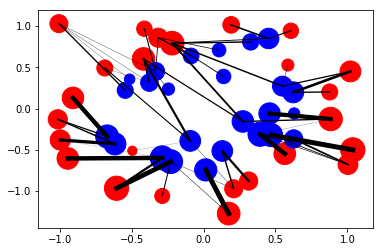

In [299]:
plt.scatter(axy[:,0], axy[:,1], s = a**(1/2)*2000, c="red")
plt.scatter(bxy[:,0], bxy[:,1], s = b**(1/2)*2000, c="blue")
maxP = np.max(P)
for i in range(n):
    for j in range(m):
        plt.plot([axy[i,0], bxy[j,0]], [axy[i,1], bxy[j,1]], linewidth=P[i,j]*5/maxP, linestyle="-", c="black")

In [300]:
cost = np.sum(np.multiply(C,P))
print(f"Total cost : {cost}")

Total cost : 0.3384302678394907


In [301]:
f - f[0]

<tf.Tensor: id=89912727, shape=(25,), dtype=float64, numpy=
array([ 0.        , -0.40612675, -0.09682492,  0.11612338, -0.01569643,
        0.62041177, -0.39089447,  0.40452261, -0.21012488,  0.31207676,
       -0.61054861, -0.18531634, -0.36689393,  0.04750865,  0.3510685 ,
       -0.35963982, -0.40599837, -0.20042494, -0.13059894,  1.13111931,
       -0.54945911, -0.4784181 , -0.35646123,  0.51326365, -0.0984898 ])>

In [302]:
g + f[0] - eps*np.log(b)

<tf.Tensor: id=89912734, shape=(25,), dtype=float64, numpy=
array([ 0.15754568, -0.10591257,  0.57134086,  0.55127887,  0.43558857,
        0.73729459, -0.4126689 , -0.14815825,  0.64023509,  0.63387011,
        0.54025367, -0.3478643 , -0.31266822,  0.40304558,  0.45350015,
       -0.1131543 ,  0.0460184 , -0.43521674,  0.65123646, -0.22832316,
        0.24448552,  0.36894664,  0.78036454,  0.4220888 , -0.26526743])>

In [96]:
def getKstab(C, eps, alpha, beta):
    return tf.math.exp(-(C - tf.expand_dims(alpha, axis=1) - tf.expand_dims(beta, axis=0))/eps)

def getK(C, eps):
    return tf.math.exp(-C/eps)

def n_inf(x):
    return tf.math.reduce_max(tf.math.abs(x))

def scaling_stabilized(C, a, b, eps, alpha0, beta0, getK=getK, getKstab=getKstab):
    n, m = alpha0.shape[0], beta0.shape[0]
    alpha, beta = tf.expand_dims(alpha0, axis=1), tf.expand_dims(beta0, axis=1)
    u = tf.ones((n,1), dtype=tf.float64)/n
    v = tf.ones((m,1), dtype=tf.float64)/m
    Tau = 1
    a = tf.expand_dims(a, axis=1)
    b = tf.expand_dims(b, axis=1)
    niter = 0
    
    while True:
        alphab, betab = alpha, beta
        K = getK(C, eps)
        while n_inf(u) < Tau and n_inf(v) < Tau:
            u = a/(K@v)/tf.math.exp(alpha/eps)
            v = b/(tf.transpose(K)@u)/tf.math.exp(beta/eps)
        alpha += eps * tf.math.log(u)
        beta += eps* tf.math.log(v)
        u = tf.ones((n,1), dtype=tf.float64)/n
        v = tf.ones((m,1), dtype=tf.float64)/m
        
        niter += 1
        if niter%2 == 0:
            diffalpha, diffbeta = n_inf(alpha - alphab), n_inf(beta-betab)
            print(f"Diff alpha = {diffalpha}, Diff beta = {diffbeta}")

        if n_inf(alpha-alphab) < 1e-10 or n_inf(beta-betab) < 1e-10:
            break
    return alpha, beta

In [97]:
def scaling_stab_epsscale(C, a, b, alpha0, beta0, getK=getK, getKstab=getKstab):
    for eps in 10**(-np.arange(1., 3.)):
        alpha0, beta0 = scaling_stabilized(C, a, b, eps, alpha0, beta0, getK=getK, getKstab=getKstab)
        alpha0, beta0 = alpha0[:,0], beta0[:,0]
    return alpha0, beta0

In [275]:
a

array([[0.0339874 ],
       [0.08627196],
       [0.06642432],
       [0.05432488],
       [0.01415781],
       [0.01415562],
       [0.00527076],
       [0.0786006 ],
       [0.0545478 ],
       [0.06425359],
       [0.00186793],
       [0.08801385],
       [0.07553947],
       [0.01926858],
       [0.01649959],
       [0.01664292],
       [0.02760827],
       [0.04761868],
       [0.03919657],
       [0.0264274 ],
       [0.0555222 ],
       [0.01265828],
       [0.02651048],
       [0.03324527],
       [0.04138578]])

In [276]:
f.shape

TensorShape([25])

In [277]:
alpha, beta = scaling_stab_epsscale(C, a, b, np.ones((n,))/n, np.ones((m,))/m)

In [278]:
alpha.shape

TensorShape([25, 1])

In [279]:
P = tf.linalg.diag(alpha[:,0])@tf.exp(-C/eps)@tf.linalg.diag(beta[:,0])

In [280]:
P = P.numpy()

In [281]:
erra = np.max(np.sum(P, axis=1) - a)
errb = np.max(np.sum(P, axis=0) - b)
print(f"Marginals errors : a = {erra}, b = {errb}")

Marginals errors : a = -0.0013362594827632118, b = -0.002557970983698042


In [282]:
cost = np.sum(np.multiply(C,P))
print(f"Total cost : {cost}")

Total cost : 3.3237640923981755e-05
